In [349]:
def calc_func(sample, x):
    return numpy.mean(sample <= x)

In [351]:
import numpy
from scipy.stats import expon
numpy.random.seed(42)
N = 5000
n_array = numpy.arange(10, N, 10)
X = expon().rvs(N)
x = 3
F_x = expon().cdf(x)
delta = []

for n in n_array:
    F_n_x = calc_func(X[:n], x)
    delta.append(F_n_x - F_x)

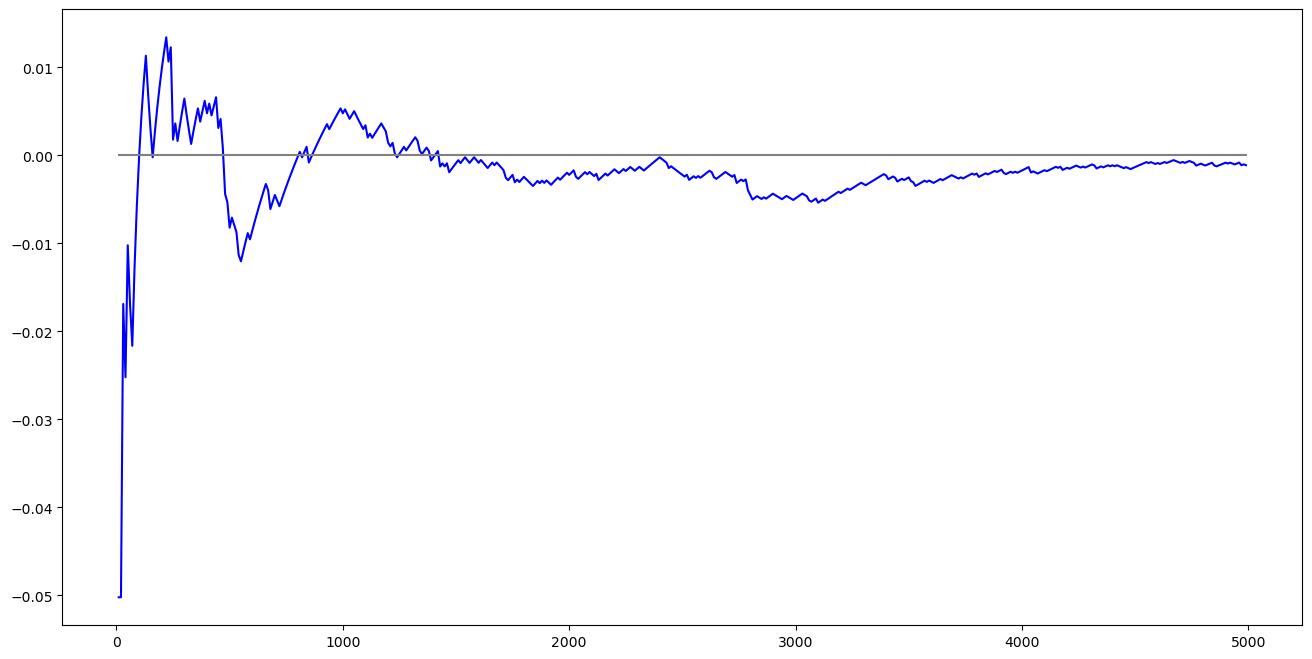

In [353]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(n_array, delta, c='blue')
plt.plot(n_array, [0] * len(n_array), c='grey')

Наконец, проверим критерий колмогорова. H0: А верно ли что сэмпл получен из данного распределения? Теоретически мы этого не знаем :)

In [356]:
from scipy.stats import norm, kstest

In [358]:
sample = norm(0.15, 0.04).rvs(10)
print(sample)
Dn, p = kstest(rvs=sample, cdf='norm', args=(0.15, 0.04))
p

[0.12612103 0.05438783 0.13351117 0.18653895 0.1715052  0.16712745
 0.13880027 0.09883877 0.17061177 0.11662873]


0.694923729660154

Напишем критерий Колмогорова для трудной гипотезы. Она будет отличаться тем, что мы не знаем параметры нормального распределения, а попытаемся их посчитать в ручную теоретически

In [361]:
def estimated_ktest(sample):
    mu = numpy.mean(sample)
    sigma = numpy.std(sample, ddof=1)
    dist = norm(loc=mu, scale=sigma)
    return kstest(rvs=sample, cdf=dist.cdf).pvalue

In [363]:
N = 1000
num = norm(loc=100, scale=10).rvs(N)
den = norm(loc=1000, scale=25).rvs(N)
sample = num / den
estimated_ktest(sample)

0.8389138220509537

На первый взгляд вроде всё хорошо. Но надо проверить через Монте-Карло

In [366]:
def check_criterion(criterion, sample_size, N_exp=10000, to_print=True):
    numpy.random.seed(42)
    bad_cnt=0
    alpha = 0.05
    for i in range(int(N_exp)):
        sample = norm(loc=100, scale=10).rvs(sample_size)
        pvalue = criterion(sample)
        bad_cnt += (pvalue <= alpha)
    if to_print:
        print(f'FPR: {bad_cnt / N_exp}')
        print(f'CI: {proportion_confint(count=bad_cnt, nobs=N_exp, alpha=0.05, method='wilson')}')

In [368]:
from statsmodels.stats.proportion import proportion_confint
check_criterion(estimated_ktest, sample_size=1000, N_exp=10000)

FPR: 0.0
CI: (0.0, 0.0003839983706765959)


Так как мы получили 0, то это не очень хорошо. Критерий в таких случаях неправильно применен. Здесь произошло: справедливую и несправедливую Н0 отвергает очень часто, а так же этот критерий очень маломощный. Здесь отвратительно, что значения, оцененные по выборке, более точно подходящие, более хорошо описывают наши данные. Что делать, если не можем оценить? 

In [370]:
sample = norm(loc=100, scale=10).rvs(1000)
mu = numpy.mean(sample)
sigma = numpy.std(sample, ddof=1)
mu, sigma

(99.87828132698765, 9.864168805382198)

Мы видим что оцененные параметры отличаются имеено поэтому они делают фпр 0. Теперь посмотриим на критерий Колмогорова с поправкой Лилиефорса

In [372]:
from statsmodels.stats.diagnostic import lilliefors
Dn, p_value = lilliefors(sample, dist='norm', pvalmethod='table')
p_value

0.3254219062545903

In [373]:
def lilliefors_crit(sample):
    return lilliefors(sample, dist='norm', pvalmethod='table')[1]
lilliefors_crit(sample)

0.3254219062545903

In [378]:
check_criterion(lilliefors_crit, sample_size=1000, N_exp=10000)

FPR: 0.0384
CI: (0.0348075417687003, 0.04234696552710831)


FPR конечно занижен, но он уже не равен 0

Теперь рассмотрим критерий Шапиро-Уилка, кторый проверяет получена ли выборка из нормального распределения или неть, ну и прогоним его через монте-карло

In [382]:
from scipy.stats import shapiro
sample = norm(loc=100, scale=10).rvs(15)
shapiro(sample)

ShapiroResult(statistic=0.9545792756874288, pvalue=0.5992095066791989)

In [384]:
def shapiro_crit(sample):
    return shapiro(sample)[1]
check_criterion(shapiro_crit, sample_size=1000, N_exp=100000)

FPR: 0.05145
CI: (0.05009793546497082, 0.05283652493832744)


Напишем функцию для проверки нормальное ли у нас распределение. QQ-plot - график, который помогает нам сказать, получена выборка из нормального распределения или нет

In [387]:
def qq_plot(sample):
    sample.sort()
    sample_quantiles = sample[0:-1]
    N = len(sample)
    x = [i / N for i in range(1, N)]
    theoretical_quantiles = norm().ppf(x)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth = 1.0, color = 'orange')
    

/var/folders/jm/lyl2x71d4p3019zwc7l2sdm40000gn/T/ipykernel_6468/507238295.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth = 1.0, color = 'orange')


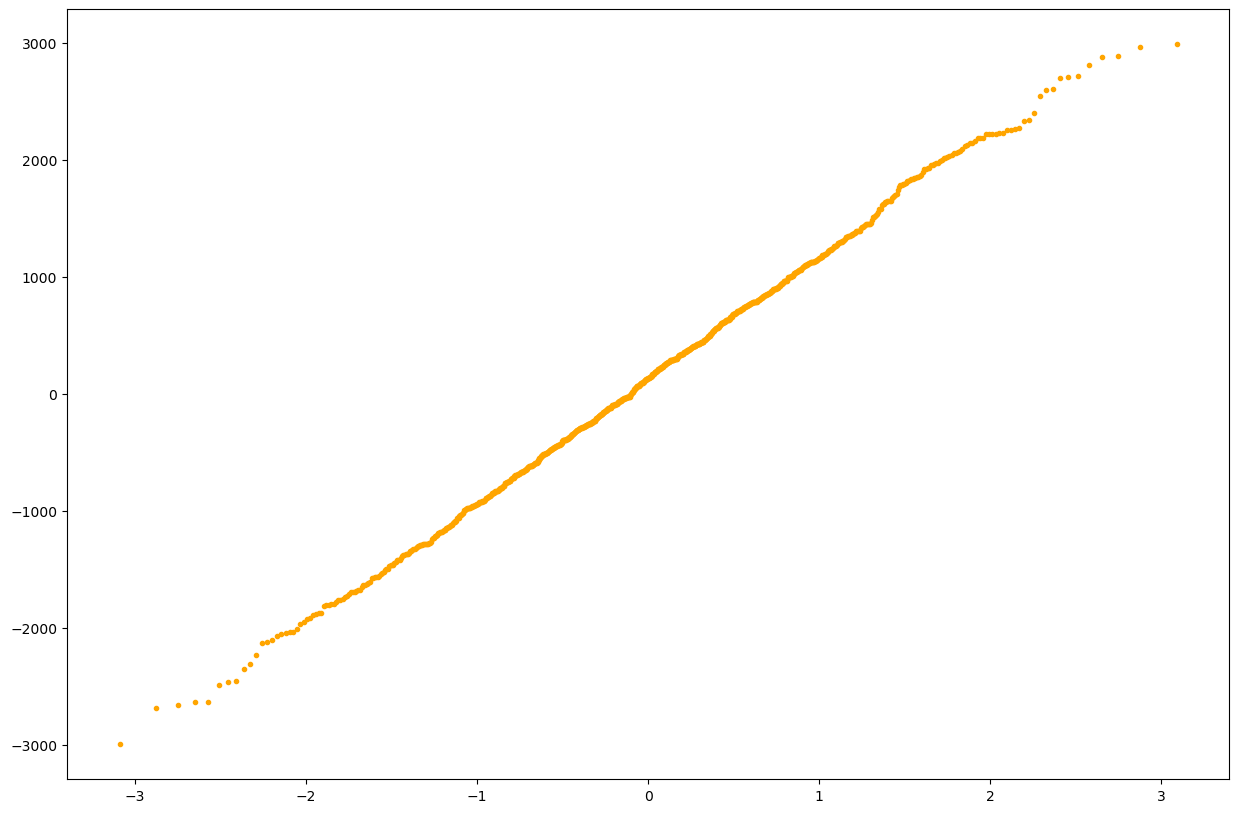

In [389]:
import matplotlib.pyplot as plt
numpy.random.seed(101)
sample = norm(loc=100, scale=1000).rvs(1000)
qq_plot(sample)

График похож на прямую, значит эта выборка точно получена из нормального распределения, но здесь нет никакого строгого математического правила, только визуализация

/var/folders/jm/lyl2x71d4p3019zwc7l2sdm40000gn/T/ipykernel_6468/507238295.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth = 1.0, color = 'orange')


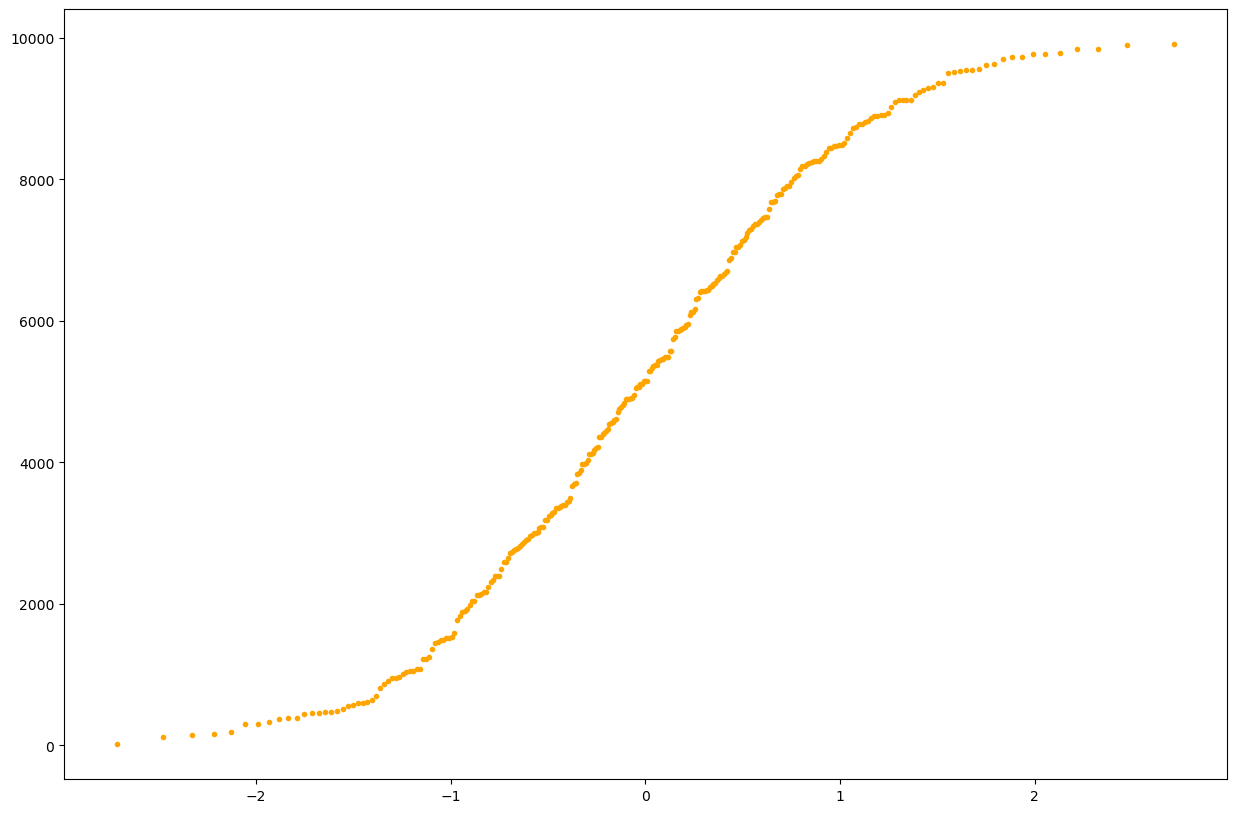

In [392]:
import random
sample_1 = [random.randint(1, 10000) for _ in range(300)]
sample_1
qq_plot(sample_1)

In [394]:
shapiro(sample_1)

ShapiroResult(statistic=0.9508917538192855, pvalue=1.7833195896303564e-08)

/var/folders/jm/lyl2x71d4p3019zwc7l2sdm40000gn/T/ipykernel_6468/507238295.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth = 1.0, color = 'orange')


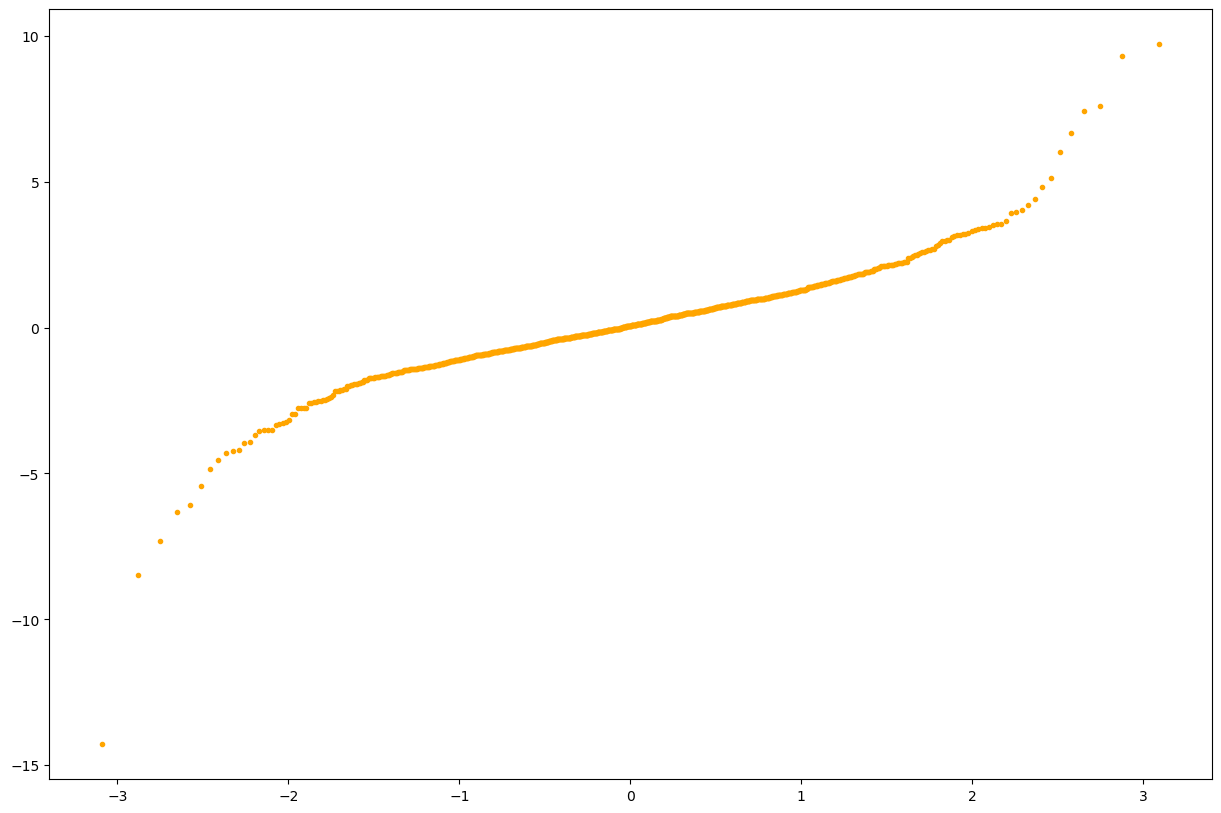

In [396]:
from scipy.stats import t
numpy.random.seed(102)
sample = t(df=3).rvs(1000)
qq_plot(sample)

In [398]:
shapiro(sample)

ShapiroResult(statistic=0.8834507397843283, pvalue=9.490973987845434e-27)

Так же можно в ручную не писать эту функцию а просто импортировать её из библиотеки если вдруг нам хочется посмотретьь на линию.

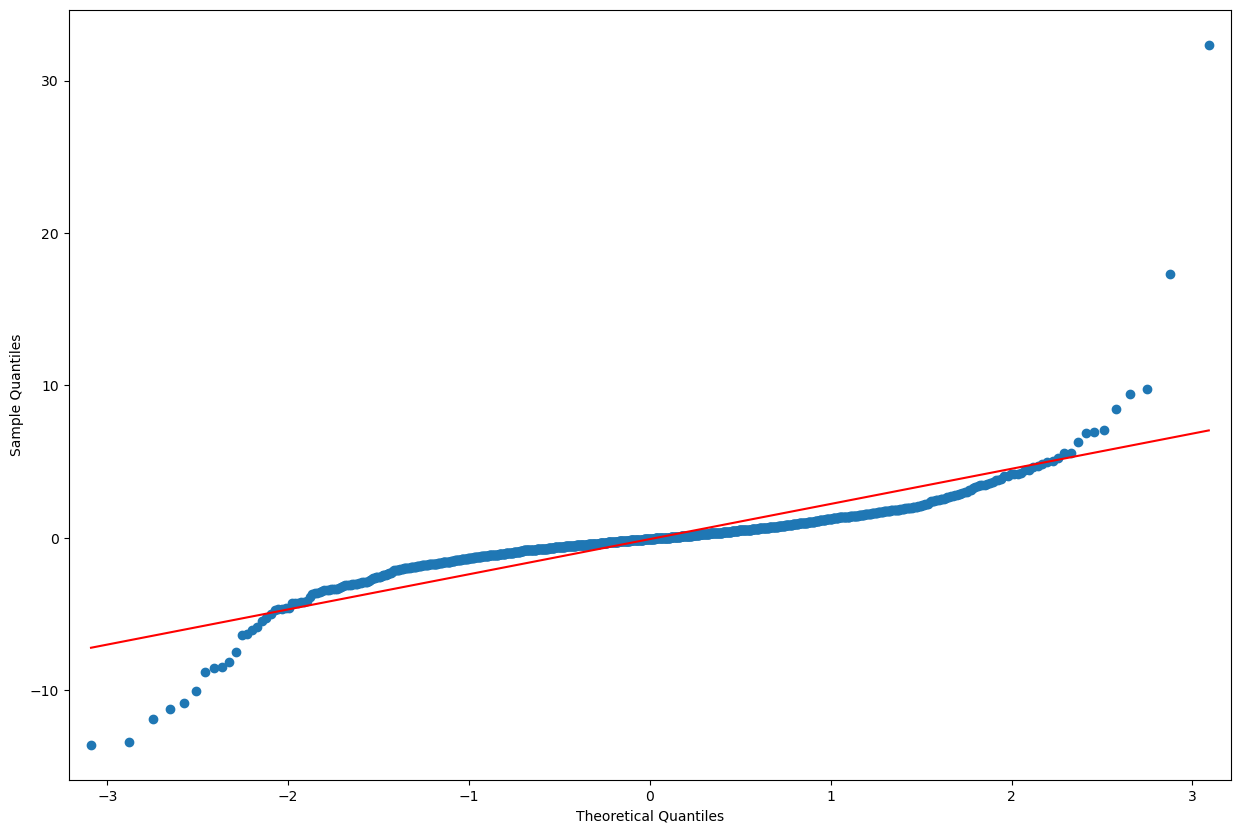

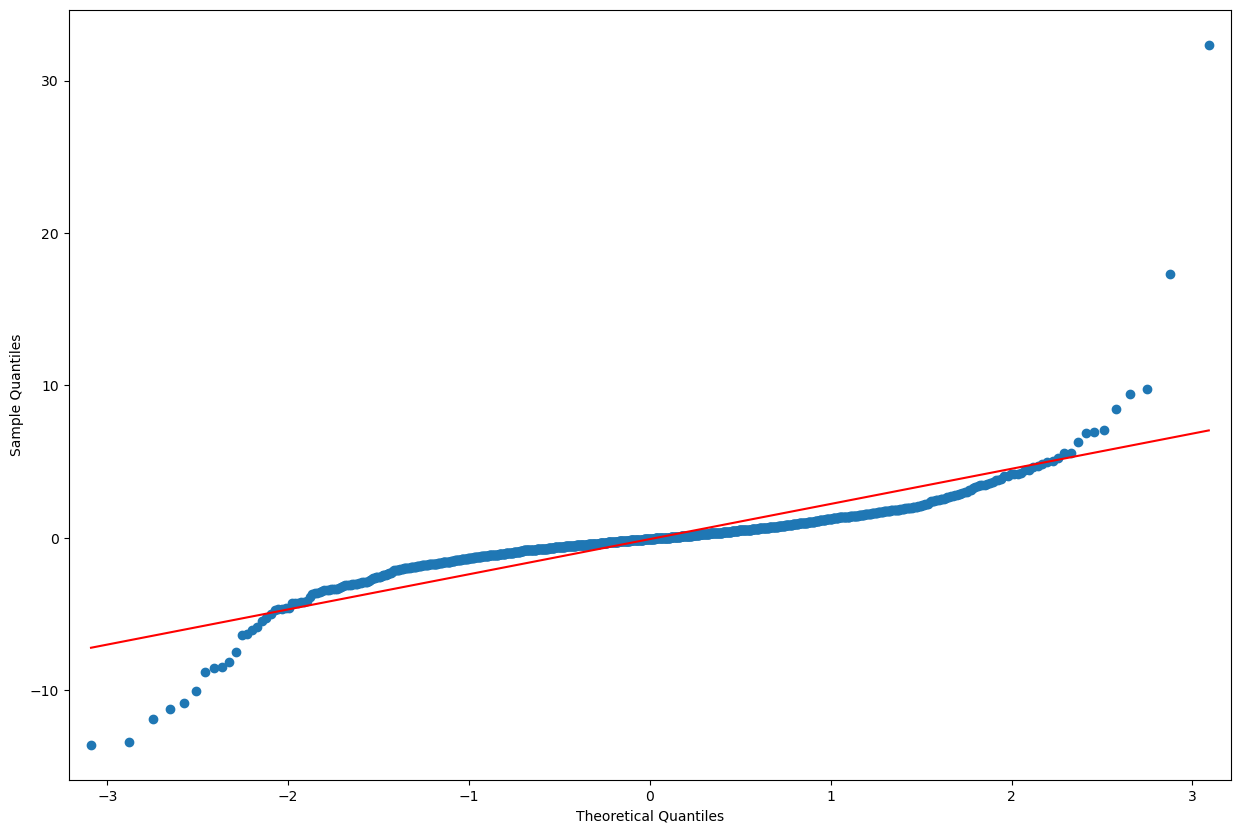

In [401]:
from statsmodels.graphics.gofplots import qqplot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
qqplot(data=t(df=2).rvs(1000), line='s', ax=ax)

теперь посмотрим, стоит ли применять его для проверки распределения на нормальность (спойлер - не стоит)

In [404]:
numpy.random.seed(35)
N_exp = 10000
sample_size = 5
bad_cnt = 0
alpha = 0.05

from scipy.stats import expon
from scipy.stats import ttest_1samp
mean = 10
dist = expon(scale=mean)
sz = 0

for i in range(N_exp):
    sample = dist.rvs(sample_size)
    if shapiro(sample).pvalue < 0.05:
        continue
        
    p_value = ttest_1samp(sample, popmean=mean).pvalue
    bad_cnt += (p_value < alpha)
    sz += 1

In [405]:
sz/N_exp * 100

83.89

In [408]:
bad_cnt / N_exp

0.104

In [410]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(count=bad_cnt, nobs=sz, alpha=0.05, method='wilson')

(0.11709147118543192, 0.1311964857651455)

Для маленьких выборок Шапиро-Уилк имеет слишком низкую мощность. Но не надо использовать критерии согласия для Т-теста, лучше юзать критерий Колмогорова-Смирнова или Монте-Карло

Напишем функцию которая проверяет можно ли применить сюда критерий Колмогорова. Проверим с помощью Монте-Карло

In [414]:
def check_kstest(dist, sample_size, N_exp=10000, to_print=True):
    numpy.random.seed(35)
    alpha = 0.05
    bad_cnt = 0

    for i in range(N_exp):
        sample = dist.rvs(sample_size)
        p_value = kstest(sample, cdf=dist.cdf).pvalue
        bad_cnt += (p_value < alpha)
    if to_print:
        print('FPR: ', round(bad_cnt / N_exp, 3))
        print('CI: ', proportion_confint(count=bad_cnt, nobs=N_exp, alpha=0.05, method='wilson'))
    else:
        return proportion_confint(count=bad_cnt, nobs=N_exp, alpha=0.05, method='wilson')

In [416]:
sample_size = 5
dist = expon(scale=10)
check_kstest(dist, sample_size, N_exp, to_print=True)

FPR:  0.048
CI:  (0.043789399861243195, 0.05215788826519671)


In [418]:
kstest([3.2, 1.1, 2.8], [1.6, 2.3, 1.2])

KstestResult(statistic=0.6666666666666666, pvalue=0.6, statistic_location=2.3, statistic_sign=-1)

То есть критерий Колмогорова-Смирнова показывает нам из одного определения наши выборки или нет, это кайф

In [472]:
def check_monte_carlo(n_size, m_size, dist_x, dist_y, N_exp):
    positive = 0
    for i in range(N_exp):
        x = dist_x.rvs(n_size)
        y = dist_y.rvs(m_size)
        pvalue = kstest(x, y).pvalue
        if pvalue <= alpha:
            positive += 1
    positive_rate = positive / N_exp
    ci = proportion_confint(count=positive, nobs=N_exp, alpha=0.05, method='wilson')
    return positive_rate

In [474]:
N_exp = 200000
n, m = 20, 20
from scipy.stats import gamma
dist_x = gamma(5, 110)
dist_y = gamma(5, 110)
pos_rate = check_monte_carlo(n, m, dist_x, dist_y, N_exp)
print('FPR: ', pos_rate)
#print('CI: ', confint)

FPR:  0.034


Здесь мы проверяем как работает критерий Колмогорова-Смирнова для выборок размером 20

Теперь рассмотрим метод Монте-Карло для критерия Колмогорова-Смирнова для 2х зависимых выборок

In [478]:
def check_monte_carlo_for_ks_defendent_samples(n, N_exp, dist, dist_x, dist_y, alpha):
    positive = 0
    for _ in range(N_exp):
        zero_dist = dist.rvs(n)
        Y = zero_dist + dist_y.rvs(n)
        X = zero_dist + dist_x.rvs(n)
        pvalue = kstest(X, Y).pvalue
        if pvalue <= alpha:
            positive += 1
    positive_rate = positive / N_exp
    ci = proportion_confint(count=positive, nobs=N_exp, alpha=0.05, method='wilson')
    return positive_rate   

In [480]:
N_exp = 10000
n = 600
alpha = 0.05
dist = norm(0, 4)
dist_x = norm(0, 3)
dist_y = norm(0, 2)
fpr = check_monte_carlo_for_ks_defendent_samples(n=n, N_exp=N_exp, dist=dist, dist_x=dist_x, dist_y=dist_y, alpha=alpha)
print('FPR: ', fpr)
#print('CI: ', con_int)

FPR:  0.0222


In [482]:
from tqdm import tqdm

Сравним мощности нашего критерия с 2мя зависимыми выборками и с 2мя независимыми

In [503]:
tpr_list_dependent = []
tpr_list_independent = [] 
import math

#перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy.ceil(numpy.geomspace(50, 6000, 10))):
    i = int(i)
    mmk_res_independent = check_monte_carlo(
        n_size=i, m_size=i, dist_x=norm(0, 5), dist_y=norm(0, 2*math.sqrt(5)), N_exp=10000 
    )
    tpr_list_independent.append([i, mmk_res_independent])
    mmk_res_dependent = check_monte_carlo_for_ks_defendent_samples(
        n=i, N_exp=10000, dist=norm(0,4), dist_x=norm(0,3), dist_y=norm(0,2), alpha=0.05
    )
    tpr_list_dependent.append([i, mmk_res_dependent])

100%|███████████████████████████████████████████| 10/10 [02:34<00:00, 15.48s/it]


Text(0.5, 0, 'Sample size')

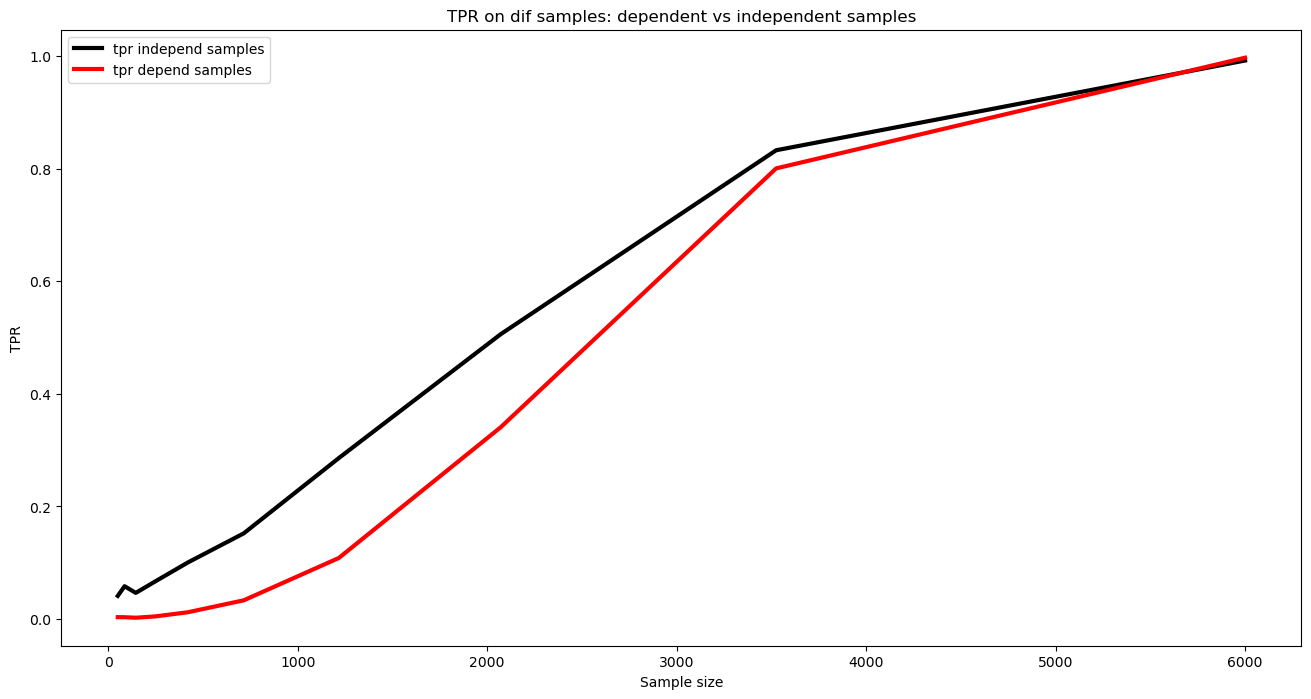

In [513]:
plt.figure(figsize=(16, 8))
plt.plot([elem[0] for elem in tpr_list_independent],
         [elem[1] for elem in tpr_list_independent], 
        color='black', linewidth=3, label='tpr independ samples')
plt.plot(
    [elem[0] for elem in tpr_list_dependent],
    [elem[1] for elem in tpr_list_dependent],
    color='red', lw=3.0, label='tpr depend samples'
)
plt.legend()
plt.title('TPR on dif samples: dependent vs independent samples')
plt.ylabel('TPR')
plt.xlabel('Sample size')

Но если посмотрим на график, то наш критерий нашего главного врача, достаточно верный, но мы смотрим это для 2х выборок размером 1000, но у нашего врача есть всего 1000 пациентов, поэтому количество пациентов в двух независимых выборках поделим на 2 и посмотрим на результат:

In [516]:
tpr_list_dependent = []
tpr_list_independent = [] 
import math

#перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy.ceil(numpy.geomspace(50, 6000, 10))):
    i = int(i)
    mmk_res_independent = check_monte_carlo(
        n_size=i // 2, m_size=i // 2, dist_x=norm(0, 5), dist_y=norm(0, 2*math.sqrt(5)), N_exp=10000 
    )
    tpr_list_independent.append([i, mmk_res_independent])
    mmk_res_dependent = check_monte_carlo_for_ks_defendent_samples(
        n=i, N_exp=10000, dist=norm(0,4), dist_x=norm(0,3), dist_y=norm(0,2), alpha=0.05
    )
    tpr_list_dependent.append([i, mmk_res_dependent])

100%|███████████████████████████████████████████| 10/10 [01:59<00:00, 11.98s/it]


Text(0.5, 0, 'Sample size')

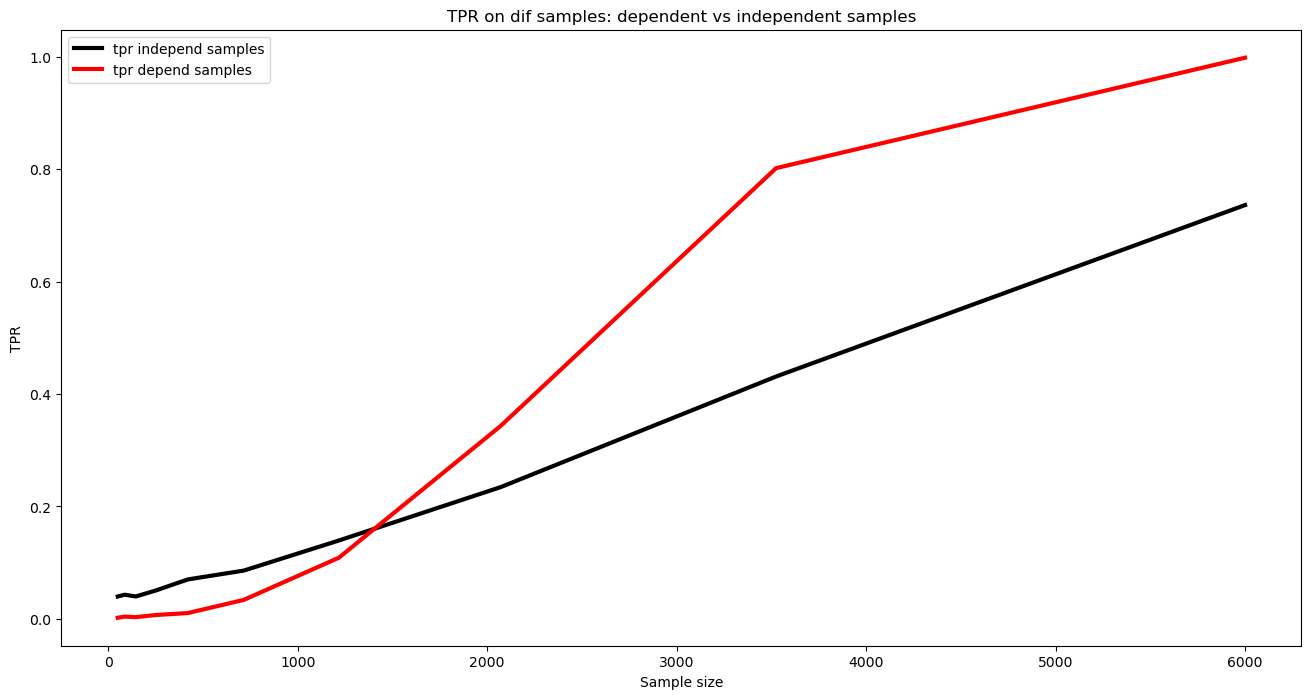

In [518]:
plt.figure(figsize=(16, 8))
plt.plot([elem[0] for elem in tpr_list_independent],
         [elem[1] for elem in tpr_list_independent], 
        color='black', linewidth=3, label='tpr independ samples')
plt.plot(
    [elem[0] for elem in tpr_list_dependent],
    [elem[1] for elem in tpr_list_dependent],
    color='red', lw=3.0, label='tpr depend samples'
)
plt.legend()
plt.title('TPR on dif samples: dependent vs independent samples')
plt.ylabel('TPR')
plt.xlabel('Sample size')

Мы видим что на самом деле критерий нашего главврача достаточно мощный на самом деле, если учитывать что у нас есть всего 1000 испытуемых